In [1]:
#!/usr/bin/env python
from __future__ import absolute_import, division, print_function, unicode_literals # Python 2 & 3 compatibility
import math
   
# Sky surface brightness, Gunn g & r bands
sky_mu = {'g':22.5, 'r':21.5} # AB mag/arcsec^2

# SBIG STD-8300M properties
dark_current = 0.04 # e/pixel/second
read_noise = 10.0 # e/pixel/read

# Number of photons/second/pixel at the top of atmosphere 
# that corresponds to 0 AB mag/arcsec^2, Gunn g & r bands.
gamma0 = {'g':1.79e9, 'r':1.16e9}

# Fractional overall system efficiency, Gunn g & r bands
efficiency = {'g':0.34, 'r':0.35}

def snr(sci_mu, band, total_exp_time, sub_exp_time=600, sky=sky_mu, binning=1, N=1, round_up=True):
    
    # Science count rates, uses equations 8 & 9 from Dragonfly paper to convert AB mag/arcsec^2 to e/pixel/s
    rate_sci = gamma0[band] * N * efficiency[band] * 10**(-0.4 * sci_mu) # e/pixel/second
    
    # Sky count rates, uses equations 8 & 9 from Dragonfly paper to convert AB mag/arcsec^2 to e/pixel/s
    rate_sky =  gamma0[band] * N * efficiency[band] * 10**(-0.4 * sky_mu[band]) # e/pixel/second
    
    # Number of sub-exposures
    number_subs = int(math.ceil(total_exp_time/sub_exp_time))
    if round_up and (total_exp_time != number_subs * sub_exp_time):
        total_exp_time = number_subs * sub_exp_time
        print('Rounding up total exposure time to next integer multiple of sub-exposure time:', total_exp_time)
    
    # Noise sources
    signal = rate_sci * total_exp_time # e/pixel
    sky_counts = rate_sky * total_exp_time # e/pixel
    dark_counts = dark_current * total_exp_time # e/pixel
    total_read_noise = math.sqrt(number_subs) * read_noise  # e/pixel
    
    noise = math.sqrt(signal + sky_counts + dark_counts + total_read_noise**2) # e/pixel
    
    s = binning * signal/noise # Binning increases signal to noise by the binning factor
    
    #print(s, signal, sky_counts, dark_counts, total_read_noise**2)
        
    return s


def etc(sci_mu, band, snr_target, sky=sky_mu, sub_exp_time=600, binning=1, N=1):
    
    # Convert target SNR per binned pixel to SNR per unbinned pixel
    snr_target /= binning
    
    # Science count rates, uses equations 8 & 9 from Dragonfly paper to convert AB mag/arcsec^2 to e/pixel/s
    rate_sci = gamma0[band] * N * efficiency[band] * 10**(-0.4 * sci_mu) # e/pixel/second
    
    # Sky count rates, uses equations 8 & 9 from Dragonfly paper to convert AB mag/arcsec^2 to e/pixel/s
    rate_sky =  gamma0[band] * N * efficiency[band] * 10**(-0.4 * sky_mu[band]) # e/pixel/second
    
    # If required total exposure time is much greater than the length of a sub-exposure then
    # all noise sources (including read noise) are proportional to t^0.5 and we can use a 
    # simplified expression to estimate total exposure time.
    total_exp_time = snr_target**2 * (rate_sci + rate_sky + dark_current + read_noise**2/sub_exp_time) / rate_sci**2
    
    # The simplified expression underestimates read noise due to fractional number of sub-exposure,
    # the effect will be neglible unless the total exposure time is very short but we can fix it anyway...
    # First round up to the next integer number of sub-exposures:
    number_subs = int(math.ceil(total_exp_time / sub_exp_time))
    # If the SNR has dropped below the target value as a result of the extra read noise add another sub
    # Note: calling snr() here is horribly inefficient as it recalculates a bunch of stuff but I don't care.
    while snr(sci_mu, band, number_subs*sub_exp_time, sub_exp_time, binning, N, round_up=False) < snr_target:
        print("Adding a sub-exposure to overcome read noise!")
        number_subs += 1
    
    return number_subs*sub_exp_time, number_subs


def limit(band, total_exp_time, snr_target, sky_mu=sky_mu, sub_exp_time=600, binning=1, N=1, round_up=True
         , enable_read_noise=True, enable_sky_noise=True, enable_dark_noise=True):
    
    # Convert target SNR per binned pixel to SNR per unbinned pixel
    snr_target /= binning
    
    # Sky count rates, uses equations 8 & 9 from Dragonfly paper to convert AB mag/arcsec^2 to e/pixel/s
    rate_sky =  gamma0[band] * N * efficiency[band] * 10**(-0.4 * sky_mu[band]) # e/pixel/second
    
    # Number of sub-exposures
    number_subs = int(math.ceil(total_exp_time/sub_exp_time))
    if round_up and (total_exp_time != number_subs * sub_exp_time):
        total_exp_time = number_subs * sub_exp_time
        print('Rounding up total exposure time to next integer multiple of sub-exposure time:', total_exp_time)
        
    # Noise sources
    sky_counts = rate_sky * total_exp_time if enable_sky_noise else 0.0 # e/pixel
    dark_counts = dark_current * total_exp_time if enable_dark_noise else 0.0 # e/pixel
    total_read_noise = math.sqrt(number_subs) * read_noise if enable_read_noise else 0.0 # e/pixel
    
    # Calculate science count rate for target signal to noise ratio
    a = total_exp_time**2
    b = -snr_target**2 * total_exp_time
    c = -snr_target**2 * (sky_counts + dark_counts + total_read_noise**2)
    rate_sci = (-b + math.sqrt(b**2 - 4*a*c))/(2*a) # e/pixel/second
    
    # Convert science count rate to surface brightness with inverse of equations 8 & 9 from Dragonfly paper
    sci_mu = -2.5 * math.log10(rate_sci / (gamma0[band] * N * efficiency[band])) # AB mag/arcsec^2
    
    return sci_mu

if __name__ == '__main__':
    snr_g, snr_r = snr(30.0, 'g', 150000), snr(30.0, 'r', 150000)
    print('g\'-band S/N =', snr_g)
    print('r\'-band S/N =', snr_r)


g'-band S/N = 0.26095504278226683
r'-band S/N = 0.14196043946490822


In [2]:
snr(26.0, 'g', 13000)

Rounding up total exposure time to next integer multiple of sub-exposure time: 13200


3.0381536605570645

In [3]:
etc(22, 'g', 5.0, sub_exp_time=60)

(120, 2)

In [4]:
limit('g', 100000, 3.0, sky_mu={'g':22.5, 'r':21.5}, sub_exp_time=300)

Rounding up total exposure time to next integer multiple of sub-exposure time: 100200


27.023816828941673

In [5]:
limit('g', 100000, 3.0, sky_mu={'g':24.0, 'r':23.0}, sub_exp_time=600)

Rounding up total exposure time to next integer multiple of sub-exposure time: 100200


27.56584693329358

In [6]:
%matplotlib inline

In [7]:
import numpy
import math
import matplotlib.pyplot as pyplot

In [8]:
ts = numpy.arange(10,1001,10)
ts

array([  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  110,
        120,  130,  140,  150,  160,  170,  180,  190,  200,  210,  220,
        230,  240,  250,  260,  270,  280,  290,  300,  310,  320,  330,
        340,  350,  360,  370,  380,  390,  400,  410,  420,  430,  440,
        450,  460,  470,  480,  490,  500,  510,  520,  530,  540,  550,
        560,  570,  580,  590,  600,  610,  620,  630,  640,  650,  660,
        670,  680,  690,  700,  710,  720,  730,  740,  750,  760,  770,
        780,  790,  800,  810,  820,  830,  840,  850,  860,  870,  880,
        890,  900,  910,  920,  930,  940,  950,  960,  970,  980,  990,
       1000])

In [9]:
lgs = [limit('g', t, 3.0, sub_exp_time=t) for t in ts]
lrs = [limit('r', t, 3.0, sub_exp_time=t) for t in ts]

lgrs = [limit('g', t, 3.0, sub_exp_time=t, enable_read_noise=False) for t in ts]
lrrs = [limit('r', t, 3.0, sub_exp_time=t, enable_read_noise=False) for t in ts]

lgds = [limit('g', t, 3.0, sub_exp_time=t, enable_dark_noise=False) for t in ts]
lrds = [limit('r', t, 3.0, sub_exp_time=t, enable_dark_noise=False) for t in ts]

lgss = [limit('g', t, 3.0, sub_exp_time=t, enable_sky_noise=False) for t in ts]
lrss = [limit('r', t, 3.0, sub_exp_time=t, enable_sky_noise=False) for t in ts]

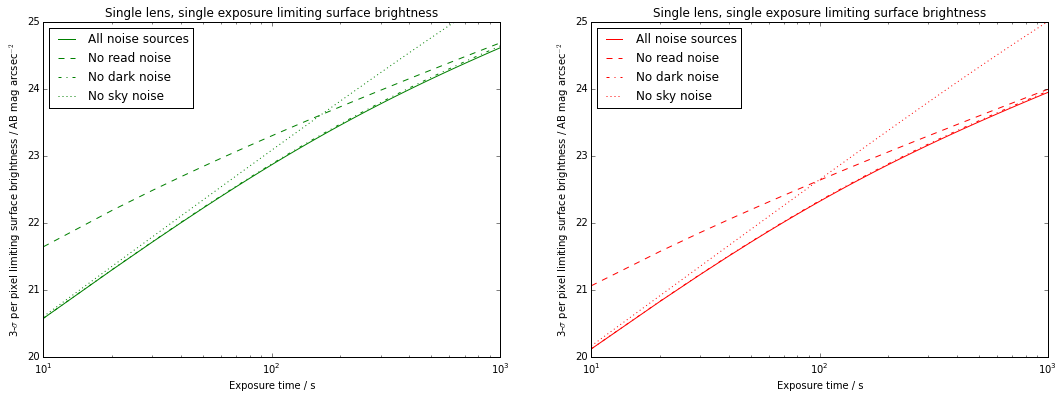

In [10]:
pyplot.subplot(1,2,1)

pyplot.semilogx(ts, lgs, 'g-', label='All noise sources')
pyplot.semilogx(ts, lgrs, 'g--', label='No read noise')
pyplot.semilogx(ts, lgds, 'g-.', label='No dark noise')
pyplot.semilogx(ts, lgss, 'g:', label='No sky noise')
pyplot.legend(loc='best')
pyplot.ylim(20,25)
pyplot.xlabel('Exposure time / s')
pyplot.ylabel('3-$\sigma$ per pixel limiting surface brightness / AB mag arcsec$^{-2}$')
pyplot.title('Single lens, single exposure limiting surface brightness')

pyplot.subplot(1,2,2)

pyplot.semilogx(ts, lrs, 'r-', label='All noise sources')
pyplot.semilogx(ts, lrrs, 'r--', label='No read noise')
pyplot.semilogx(ts, lrds, 'r-.', label='No dark noise')
pyplot.semilogx(ts, lrss, 'r:', label='No sky noise')
pyplot.legend(loc='best')
pyplot.ylim(20,25)
pyplot.xlabel('Exposure time / s')
pyplot.ylabel('3-$\sigma$ per pixel limiting surface brightness / AB mag arcsec$^{-2}$')
pyplot.title('Single lens, single exposure limiting surface brightness')

pyplot.gcf().set_size_inches(18,6)

pyplot.savefig('limit.png')

In [11]:
limit('r', 540, 3.0, sub_exp_time=60)

23.157065531393943

In [12]:
limit('r', 60, 3.0, sub_exp_time=60)

21.879653639744497

In [13]:
limit('r', 540, 3.0, sub_exp_time=60) - limit('r', 60, 3.0, sub_exp_time=60)

1.2774118916494466

In [14]:
18 - (limit('r', 540, 3.0, sub_exp_time=60) - limit('r', 60, 3.0, sub_exp_time=60))

16.722588108350553

In [15]:
18 - (limit('r', 540, 3.0, sub_exp_time=60) - limit('g', 60, 3.0, sub_exp_time=60))

17.240091133926192

In [16]:
def theta_max(F):
    return math.atan(1/(2*F))

In [17]:
def lambda_shift(theta, n_eff):
    return math.sqrt(1 - (math.sin(theta)/n_eff)**2)

In [18]:
def NB_filter(wave, wave_c, FWHM, w):
    if abs(wave - wave_c) > 0.5*(1 + w)*FWHM:
        return 0.0
    elif abs(wave - wave_c) < 0.5*(1-w)*FWHM:
        return 1.0
    else:
        return 1 - (abs(wave - wave_c) - 0.5*(1-w)*FWHM)/(w*FWHM) 

In [19]:
def fast_NB_filter(wave, wave_c, FWHM, w, F, n_eff, n_thetas):
    thetas = numpy.linspace(0, theta_max(F), n_thetas)
    num = math.fsum([NB_filter(wave/lambda_shift(theta, n_eff), wave_c, FWHM, w)*math.sin(theta) for theta in thetas])
    denom = math.fsum(math.sin(theta) for theta in thetas)
    return num/denom

In [20]:
H_a = 656.28

In [21]:
gc = (401+550) / 2.0
gf = 550 - 401.0
gw = 0.01

In [22]:
rc = (562+695) / 2.0
rf = 695 - 562.0
rw = 0.01

In [23]:
thetas = numpy.linspace(0, theta_max(2.8), 100)

In [24]:
waves = numpy.linspace(645,662,200)

In [25]:
waves2 = numpy.linspace(390, 560, 200)

In [26]:
waves3 = numpy.linspace(550, 705, 200)

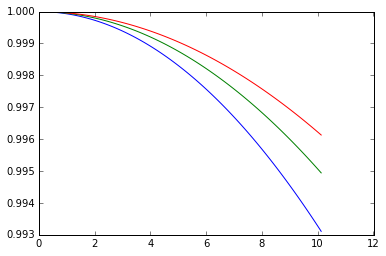

In [27]:
pyplot.plot(numpy.degrees(thetas), [lambda_shift(theta, 1.5) for theta in thetas])
pyplot.plot(numpy.degrees(thetas), [lambda_shift(theta, 1.75) for theta in thetas])
pyplot.plot(numpy.degrees(thetas), [lambda_shift(theta, 2.0) for theta in thetas])


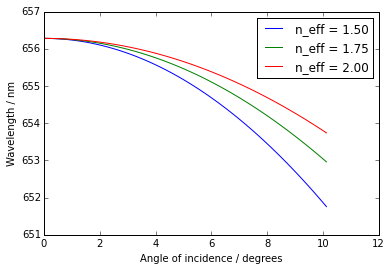

In [28]:
pyplot.plot(numpy.degrees(thetas), [H_a * lambda_shift(theta, 1.5) for theta in thetas], label='n_eff = 1.50')
pyplot.plot(numpy.degrees(thetas), [H_a * lambda_shift(theta, 1.75) for theta in thetas], label='n_eff = 1.75')
pyplot.plot(numpy.degrees(thetas), [H_a * lambda_shift(theta, 2.0) for theta in thetas], label='n_eff = 2.00')
pyplot.legend()
pyplot.xlabel('Angle of incidence / degrees')
pyplot.ylabel('Wavelength / nm')

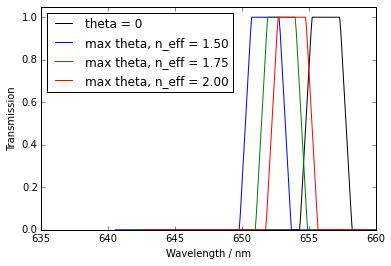

In [29]:
pyplot.plot(waves, [NB_filter(wave, H_a, 3.0, 0.3) for wave in waves], 'k', label ='theta = 0')
pyplot.plot(waves*lambda_shift(theta_max(2.8), 1.5), [NB_filter(wave, H_a, 3.0, 0.3) for wave in waves], label='max theta, n_eff = 1.50' )
pyplot.plot(waves*lambda_shift(theta_max(2.8), 1.75) , [NB_filter(wave, H_a, 3.0, 0.3) for wave in waves], label='max theta, n_eff = 1.75')
pyplot.plot(waves*lambda_shift(theta_max(2.8), 2.0) , [NB_filter(wave, H_a, 3.0, 0.3) for wave in waves], label='max theta, n_eff = 2.00')
pyplot.xlim(635,660)
pyplot.ylim(0,1.05)
pyplot.legend(loc=2)
pyplot.xlabel('Wavelength / nm')
pyplot.ylabel('Transmission')

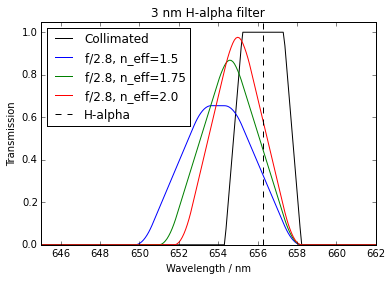

In [30]:
pyplot.plot(waves, [NB_filter(wave, H_a, 3.0, 0.3) for wave in waves], 'k', label='Collimated')
pyplot.plot(waves, [fast_NB_filter(wave, H_a, 3.0, 0.3, 2.8, 1.5, 100) for wave in waves], 'b', label='f/2.8, n_eff=1.5')
pyplot.plot(waves, [fast_NB_filter(wave, H_a, 3.0, 0.3, 2.8, 1.75, 100) for wave in waves], 'g', label='f/2.8, n_eff=1.75')
pyplot.plot(waves, [fast_NB_filter(wave, H_a, 3.0, 0.3, 2.8, 2.00, 100) for wave in waves], 'r', label='f/2.8, n_eff=2.0')
pyplot.plot([H_a, H_a], [0,1.05], 'k--', label='H-alpha')
pyplot.title('3 nm H-alpha filter')
pyplot.xlim(645,662)
pyplot.ylim(0,1.05)
pyplot.legend(loc=2)
pyplot.xlabel('Wavelength / nm')
pyplot.ylabel('Transmission')
pyplot.savefig('3nmHaf28.png')

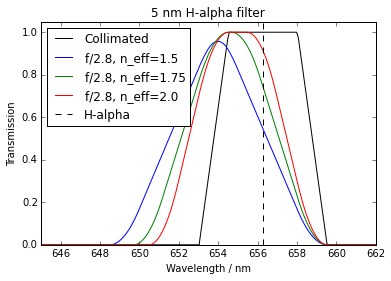

In [31]:
pyplot.plot(waves, [NB_filter(wave, H_a, 5.0, 0.3) for wave in waves], 'k', label='Collimated')
pyplot.plot(waves, [fast_NB_filter(wave, H_a, 5.0, 0.3, 2.8, 1.5, 100) for wave in waves], 'b', label='f/2.8, n_eff=1.5')
pyplot.plot(waves, [fast_NB_filter(wave, H_a, 5.0, 0.3, 2.8, 1.75, 100) for wave in waves], 'g', label='f/2.8, n_eff=1.75')
pyplot.plot(waves, [fast_NB_filter(wave, H_a, 5.0, 0.3, 2.8, 2.00, 100) for wave in waves], 'r', label='f/2.8, n_eff=2.0')
pyplot.plot([H_a, H_a], [0,1.05], 'k--', label='H-alpha')
pyplot.title('5 nm H-alpha filter')
pyplot.xlim(645,662)
pyplot.ylim(0,1.05)
pyplot.legend(loc=2)
pyplot.xlabel('Wavelength / nm')
pyplot.ylabel('Transmission')
pyplot.savefig('5nmHaf28.png')

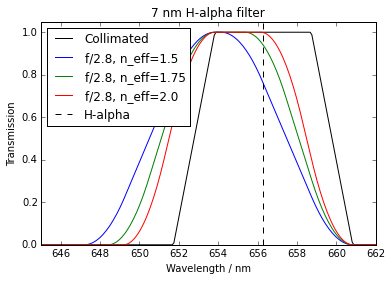

In [32]:
pyplot.plot(waves, [NB_filter(wave, H_a, 7.0, 0.3) for wave in waves], 'k', label='Collimated')
pyplot.plot(waves, [fast_NB_filter(wave, H_a, 7.0, 0.3, 2.8, 1.5, 100) for wave in waves], 'b', label='f/2.8, n_eff=1.5')
pyplot.plot(waves, [fast_NB_filter(wave, H_a, 7.0, 0.3, 2.8, 1.75, 100) for wave in waves], 'g', label='f/2.8, n_eff=1.75')
pyplot.plot(waves, [fast_NB_filter(wave, H_a, 7.0, 0.3, 2.8, 2.00, 100) for wave in waves], 'r', label='f/2.8, n_eff=2.0')
pyplot.plot([H_a, H_a], [0,1.05], 'k--', label='H-alpha')
pyplot.title('7 nm H-alpha filter')
pyplot.xlim(645,662)
pyplot.ylim(0,1.05)
pyplot.legend(loc=2)
pyplot.xlabel('Wavelength / nm')
pyplot.ylabel('Transmission')
pyplot.savefig('7nmHaf28.png')

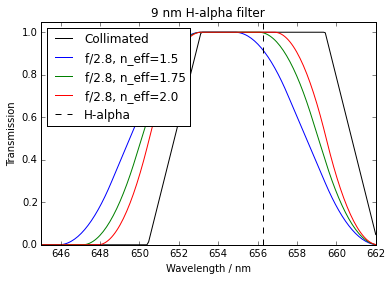

In [33]:
pyplot.plot(waves, [NB_filter(wave, H_a, 9.0, 0.3) for wave in waves], 'k', label='Collimated')
pyplot.plot(waves, [fast_NB_filter(wave, H_a, 9.0, 0.3, 2.8, 1.5, 100) for wave in waves], 'b', label='f/2.8, n_eff=1.5')
pyplot.plot(waves, [fast_NB_filter(wave, H_a, 9.0, 0.3, 2.8, 1.75, 100) for wave in waves], 'g', label='f/2.8, n_eff=1.75')
pyplot.plot(waves, [fast_NB_filter(wave, H_a, 9.0, 0.3, 2.8, 2.00, 100) for wave in waves], 'r', label='f/2.8, n_eff=2.0')
pyplot.plot([H_a, H_a], [0,1.05], 'k--', label='H-alpha')
pyplot.title('9 nm H-alpha filter')
pyplot.xlim(645,662)
pyplot.ylim(0,1.05)
pyplot.legend(loc=2)
pyplot.xlabel('Wavelength / nm')
pyplot.ylabel('Transmission')
pyplot.savefig('9nmHaf28.png')

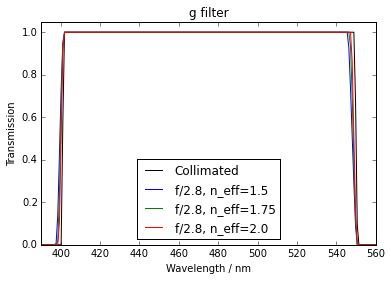

In [34]:
pyplot.plot(waves2, [NB_filter(wave, gc, gf, gw) for wave in waves2], 'k', label='Collimated')
pyplot.plot(waves2, [fast_NB_filter(wave, gc, gf, gw, 2.8, 1.5, 100) for wave in waves2], 'b', label='f/2.8, n_eff=1.5')
pyplot.plot(waves2, [fast_NB_filter(wave, gc, gf, gw, 2.8, 1.75, 100) for wave in waves2], 'g', label='f/2.8, n_eff=1.75')
pyplot.plot(waves2, [fast_NB_filter(wave, gc, gf, gw, 2.8, 2.00, 100) for wave in waves2], 'r', label='f/2.8, n_eff=2.0')
pyplot.title('g filter')
pyplot.xlim(390,560)
pyplot.ylim(0,1.05)
pyplot.legend(loc=8)
pyplot.xlabel('Wavelength / nm')
pyplot.ylabel('Transmission')
pyplot.savefig('gf28.png')

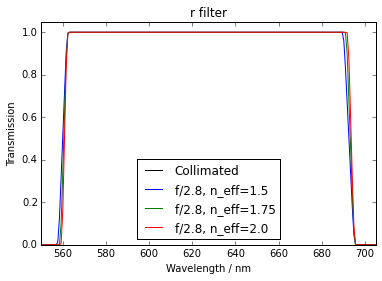

In [35]:
pyplot.plot(waves3, [NB_filter(wave, rc, rf, rw) for wave in waves2], 'k', label='Collimated')
pyplot.plot(waves3, [fast_NB_filter(wave, rc, rf, rw, 2.8, 1.5, 100) for wave in waves3], 'b', label='f/2.8, n_eff=1.5')
pyplot.plot(waves3, [fast_NB_filter(wave, rc, rf, rw, 2.8, 1.75, 100) for wave in waves3], 'g', label='f/2.8, n_eff=1.75')
pyplot.plot(waves3, [fast_NB_filter(wave, rc, rf, rw, 2.8, 2.00, 100) for wave in waves3], 'r', label='f/2.8, n_eff=2.0')
pyplot.title('r filter')
pyplot.xlim(550,705)
pyplot.ylim(0,1.05)
pyplot.legend(loc=8)
pyplot.xlabel('Wavelength / nm')
pyplot.ylabel('Transmission')
pyplot.savefig('rf28.png')

In [36]:
(5.2**2 + 3.8**2)**0.5

6.440496875241847